In [1]:
# MNIST fully connected two hidden layers.
# Proper implementation of Fisher info estimation.

# Data loading
import torch
import torchvision
import torchvision.transforms as transforms

# Network
from torch import autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

# Optimizer
import torch.optim as optim

# Standard
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

# Parameters
N_task = 20                  # Number of tasks
N_epoch = 1               # Number of epochs
batch_size = 4            # Number of samples in each minibatch
hidden_size = 800           # Number of hidden layer neurons
hidden1_dropout_prob = 0  # First hidden layer dropout probability
hidden2_dropout_prob = 0  # Second hidden layer dropout probability
lambda_L2 = 0.025           # Regularization parameter for L2
lambda_EWC = 5000              # Regularization parameter for EWC
sample_size_Fish = 1024    # Number of samples to use to estimate Fisher

# Miscellaneous options
use_cuda = 1
num_rec = 2000              # How often to record/display test accuracies, running loss, etc.

# Read data and transform

In [2]:
# MNIST-specific settings
# Height and width of images
height = 28
width = 28
# Number of labels
num_labels = 10
# Labels (for display purposes)
classes = ('0','1','2','3','4','5','6','7','8','9')

# Permutate pixels
def permutate(image, permutation):
    # c = number of channels (e.g. 3 for RGB)
    # h = height
    # w = width
    c, h, w = image.size()
    
    image = image.view(-1,c)        # Resize to 1D array
    image = image[permutation, :]   # Apply permutation
    image = image.view(c, h, w)     # Resize to original shape
    return image

# Permutations
perms = []
perms.append(np.arange(height*width))  # Non-permuted
for i in range(N_task-1):
    perms.append(np.random.permutation(perms[0]))
    
# Define transform
def trans(permutation):
    # Transforms (convert to tensor, normalize [0,1] -> [-1,1], apply permutation)
    return transforms.Compose([ \
            transforms.ToTensor(), \
            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)), \
            transforms.Lambda(lambda x: permutate(x, permutation))])
        
# Train datasets
trainsets = [torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=trans(perm)) for perm in perms]
    
# Test datasets
testsets = [torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=trans(perm)) for perm in perms]

# Show sample

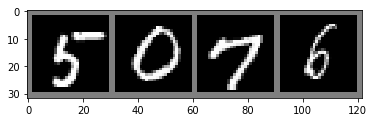

         5          0          7          6


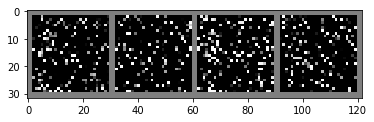

         6          9          6          0


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f2cd7939c50>>
Traceback (most recent call last):
  File "/home/david/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/home/david/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/david/anaconda3/lib/python3.6/multiprocessing/queues.py", line 345, in get
    return _ForkingPickler.loads(res)
  File "/home/david/anaconda3/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/home/david/anaconda3/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/david/anaconda3/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_

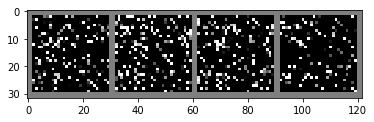

         6          8          2          7


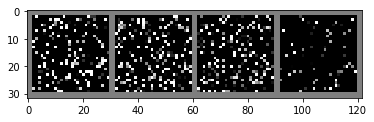

         4          2          2          1


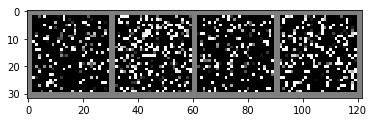

         4          8          5          9


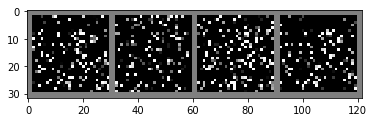

         7          5          9          7


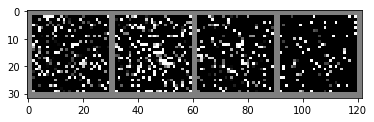

         0          8          6          1


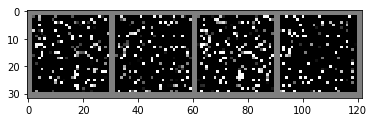

         6          4          6          1


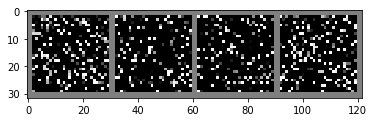

         0          3          3          4


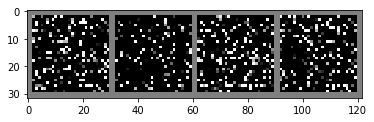

         5          6          6          0


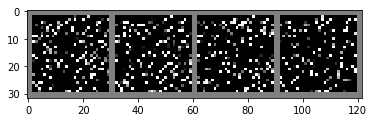

         8          8          7          9


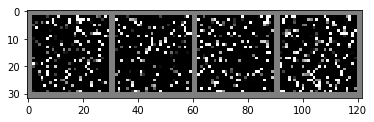

         4          3          7          0


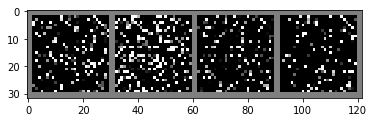

         6          0          9          1


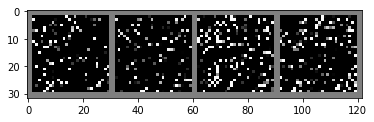

         1          9          2          5


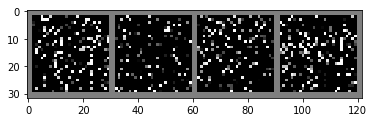

         4          5          5          2


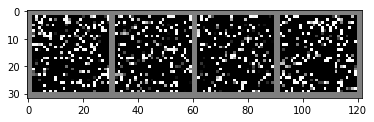

         7          8          7          6


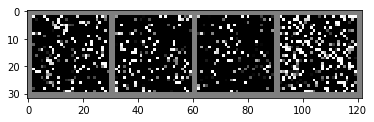

         9          5          5          8


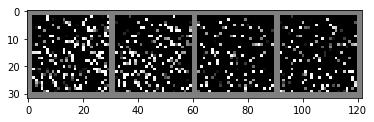

         8          8          9          0


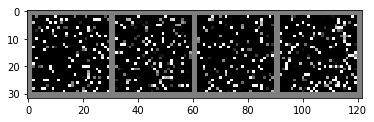

         7          2          7          9


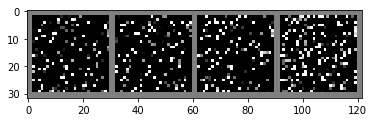

         7          7          9          6


In [3]:
# Number of samples to display per task
batch_size_sample = 4

# Train dataset loaders
trainloaders_sample = []
for i in range(N_task):
    trainloaders_sample.append(torch.utils.data.DataLoader(trainsets[i], batch_size=batch_size_sample, shuffle=True,num_workers=2))

# Show image
def imshow(img):
    img = img/2 + 0.5   # Unnormalize ([-1,1] -> [0,1])
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    
for i in range(N_task):
    trainloader_sample = trainloaders_sample[i]
    
    dataiter = iter(trainloader_sample)     # Convert to iterator
    images, labels = dataiter.next()        # Get next minibatch
    
    #if i==1:
    #    print(images.size())
    
    imshow(torchvision.utils.make_grid(images))
    plt.show()
    
    # Show labels
    print(' '.join('%10s' % classes[labels[j]] for j in range(batch_size_sample)))

# Define network model

In [4]:
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size=400, hidden1_dropout_prob=0.2, hidden2_dropout_prob=0.5):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.fc1_drop = nn.Dropout(p=hidden1_dropout_prob)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc2_drop = nn.Dropout(p=hidden2_dropout_prob)
        self.fc3 = nn.Linear(hidden_size, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        x = self.fc3(x)

        return x

# Vanilla
net = Net(
    input_dim = height*width, \
    output_dim = num_labels, \
    hidden_size = hidden_size, \
    hidden1_dropout_prob = hidden1_dropout_prob, \
    hidden2_dropout_prob = hidden2_dropout_prob)

net_L2 = copy.deepcopy(net)
net_EWC = copy.deepcopy(net)

'''
# L2 regularization
net_L2 = Net(
    input_dim = height*width, \
    output_dim = num_labels, \
    hidden_size = hidden_size, \
    hidden1_dropout_prob = hidden1_dropout_prob, \
    hidden2_dropout_prob = hidden2_dropout_prob)
# EWC
net_EWC = Net(
    input_dim = height*width, \
    output_dim = num_labels, \
    hidden_size = hidden_size, \
    hidden1_dropout_prob = hidden1_dropout_prob, \
    hidden2_dropout_prob = hidden2_dropout_prob)
    
'''

'\n# L2 regularization\nnet_L2 = Net(\n    input_dim = height*width,     output_dim = num_labels,     hidden_size = hidden_size,     hidden1_dropout_prob = hidden1_dropout_prob,     hidden2_dropout_prob = hidden2_dropout_prob)\n# EWC\nnet_EWC = Net(\n    input_dim = height*width,     output_dim = num_labels,     hidden_size = hidden_size,     hidden1_dropout_prob = hidden1_dropout_prob,     hidden2_dropout_prob = hidden2_dropout_prob)\n    \n'

# Define loss and optimizer

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)
optimizer_L2 = optim.SGD(net_L2.parameters(), lr=0.001)
optimizer_EWC = optim.SGD(net_EWC.parameters(),lr=0.001)

#optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)
#optimizer_L2 = optim.Adam(net_L2.parameters(), lr=0.001, weight_decay=1e-5)
#optimizer_EWC = optim.Adam(net_EWC.parameters(),lr=0.001, weight_decay=1e-5)

# Test accuracy function

In [6]:
def test_acc(net, dataset, input_dim, disp=False):
    net.eval()  # Switch to eval mode (disable dropout layer)
    testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        images = images.view(-1,input_dim)
        if torch.cuda.is_available() and use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        
    acc = correct/total
        
    if disp:
        print('Accuracy of the network on the 10000 test images: %d %%' % (100* acc))
        
    net.train() # Revert to train mode
    
    return acc

# Extra loss functions

In [ ]:
def calc_Fisher(net, dataset, sample_size = 1024):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True,num_workers=2)
    
    # Preallocate
    Fisher = [torch.zeros(x.size()) for x in list(net.parameters())]
    if torch.cuda.is_available() and use_cuda:
        Fisher = [x.cuda() for x in Fisher]
    
    # Take expectation over log-derivative squared
    num_sampled = 0 # Counter for number of samples so far
    for data, label in dataloader:
        data = data.view(1, -1)
        data = Variable(data)
        label = Variable(label)
        if torch.cuda.is_available() and use_cuda:
            data = data.cuda()
            label = label.cuda()
        
        # Sample log likelihood

        net.eval()      # Disable dropout layer
        output = net(data)
        net.train()     # Enable dropout layer
        
        prob = F.softmax(net(data))
        
        y_sample = torch.multinomial(prob).data # Sample from model
        
        #y_sample = label.data  # Given by data
        
        logL = F.log_softmax(output)[range(1),y_sample]
        
        # First derivative
        logL_grad = autograd.grad(logL, net.parameters())
        
        # Squared & convert to tensor
        logL_grad_sq = [x.data**2 for x in logL_grad]
        
        # Accumulate Fisher
        for i in range(len(logL_grad_sq)):
            Fisher[i] += logL_grad_sq[i]
        
        num_sampled += 1
        if num_sampled >= sample_size:
            break
            
    # Average
    for i in range(len(Fisher)):
        Fisher[i] /= sample_size

    return Fisher

def calc_EWC_loss(net, fixed, Fisher):
    losses = []
    
    for p1, p2, Fish in zip(net.parameters(),fixed,Fisher):
        F = Variable(Fish)
        losses.append((F * (p1 - p2)**2).sum())
        
    return sum(losses)

def calc_L2_loss(net, fixed):
    losses = []

    for p1, p2 in zip(net.parameters(),fixed):
        
        losses.append(((p1 - p2)**2).sum())
    
    return sum(losses)

# Train

In [ ]:
# Record accuracy
time_list = []

# Each "lists" contains N_task lists that record train accuracy
acc_lists_t = [[] for i in range(N_task)]
acc_L2_lists_t = [[] for i in range(N_task)]
acc_EWC_lists_t = [[] for i in range(N_task)]

# Each "lists" contains N_task lists that record test accuracy
acc_lists = [[] for i in range(N_task)]
acc_L2_lists = [[] for i in range(N_task)]
acc_EWC_lists = [[] for i in range(N_task)]

# Record trained models after each task
param_list_L2 = []
param_list_EWC = []
Fisher_list = []
Fisher_sum = []

# CUDA
if torch.cuda.is_available() and use_cuda:
    net = net.cuda()
    net_L2 = net_L2.cuda()
    net_EWC = net_EWC.cuda()
    criterion = criterion.cuda()
    

t_start = time.time()   # Record total runtime
t_part1 = t_start        # Record partial runtime
for task in range(len(trainsets)):
    trainset = trainsets[task]
    testset = testsets[task]
    for epoch in range(N_epoch):
        # Reset running loss
        running_loss = 0.0
        running_loss_L2 = 0.0
        running_loss_EWC = 0.0
        
        # Set up training data
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True,num_workers=2)
        
        # Iterate through all train data
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            if torch.cuda.is_available() and use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
                
            # Convert to variables and resize input as 1D array
            inputs, labels = Variable(inputs), Variable(labels)
            inputs = inputs.view(-1,height*width)
            
            # Vanilla
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward
            outputs = net(inputs)
            # Backward
            original_loss = criterion(outputs, labels)
            loss = original_loss
            loss.backward()
            # Optimize
            optimizer.step()
            
            # L2 regularization
            # Zero the parameter gradients
            optimizer_L2.zero_grad()
            # Forward
            outputs_L2 = net_L2(inputs)
            # Backward
            original_loss_L2 = criterion(outputs_L2, labels)
            L2_loss = Variable(torch.zeros(1), requires_grad = True)
            if torch.cuda.is_available() and use_cuda:
                L2_loss = L2_loss.cuda()
            # Single penalty
            #if task > 0:
            #    L2_loss = L2_loss + calc_L2_loss(net_L2, param_list_L2[task-1])
            # Multiple penalties
            for t_num in range(task):
                L2_loss = L2_loss + calc_L2_loss(net_L2, param_list_L2[t_num])
            
            loss_L2 = original_loss_L2 + 0.5*lambda_L2*L2_loss
            loss_L2.backward()
            # Optimize
            optimizer_L2.step()
            
            # EWC
            # Zero the parameter gradients
            optimizer_EWC.zero_grad()
            # Forward
            outputs_EWC = net_EWC(inputs)
            # Backward
            original_loss_EWC = criterion(outputs_EWC, labels)
            EWC_loss = Variable(torch.zeros(1), requires_grad = True)
            if torch.cuda.is_available() and use_cuda:
                EWC_loss = EWC_loss.cuda()
            # Single penalty
            #if task > 0:
            #    EWC_loss = EWC_loss + calc_EWC_loss(net_EWC, param_list_EWC[task-1], Fisher_sum)
            # Multiple penalties
            for t_num in range(task):
                EWC_loss = EWC_loss + calc_EWC_loss(net_EWC, param_list_EWC[t_num],Fisher_list[t_num])
            
            loss_EWC = original_loss_EWC + 0.5*lambda_EWC*EWC_loss
            loss_EWC.backward()
            # Optimize
            optimizer_EWC.step()
            
            # print statistics
            running_loss += loss.data[0]
            running_loss_L2 += loss_L2.data[0]
            running_loss_EWC += loss_EWC.data[0]
            if (i % num_rec) == (num_rec-1): # Print every num_rec mini-batches
            
                t_part2 = time.time()
            
                print('[%d, %5d] loss: %.3f (Vanilla) %.3f (L2) %.3f (EWC), time: %.0f s' % (epoch+1,i+1,running_loss/num_rec,running_loss_L2/num_rec,running_loss_EWC/num_rec,t_part2 - t_part1))
                
                t_part1 = t_part2
                
                # Reset running loss
                running_loss = 0.0
                running_loss_L2 = 0.0
                running_loss_EWC = 0.0
                
                # Record test accuracies for each task
                for j in range(N_task):
                    acc_lists_t[j].append(test_acc(net, trainsets[j], height*width))           # Vanilla
                    acc_L2_lists_t[j].append(test_acc(net_L2, trainsets[j], height*width))     # L2
                    acc_EWC_lists_t[j].append(test_acc(net_EWC, trainsets[j], height*width))   # EWC
                    
                    acc_lists[j].append(test_acc(net, testsets[j], height*width))           # Vanilla
                    acc_L2_lists[j].append(test_acc(net_L2, testsets[j], height*width))     # L2
                    acc_EWC_lists[j].append(test_acc(net_EWC, testsets[j], height*width))   # EWC
    
    # Save models trained on the current task
    current_param_L2 = copy.deepcopy(list(net_L2.parameters()))
    param_list_L2.append(current_param_L2)
    
    current_param_EWC = copy.deepcopy(list(net_EWC.parameters()))
    param_list_EWC.append(current_param_EWC)
    
    # Calculate Fisher Info. for EWC
    Fisher = calc_Fisher(net_EWC,testset,sample_size_Fish)
    # Record Fisher (for multiple penalties)
    Fisher_list.append(Fisher)
    # Sum Fisher (for single penalty)
    if task == 0:
        Fisher_sum = copy.deepcopy(Fisher)
    else:
        for i in range(len(Fisher)):
            Fisher_sum[i] += Fisher[i]
      
t_finish = time.time()

print('Finished Training')
print('Training time: ' + str(t_finish-t_start) + ' s')

# Convert to arrays
for j in range(N_task):
    acc_lists[j] = np.array(acc_lists[j])
    acc_L2_lists[j] = np.array(acc_L2_lists[j])
    acc_EWC_lists[j] = np.array(acc_EWC_lists[j])
time_list = np.arange(len(acc_lists[0]))


/home/david/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:110: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[1,  2000] loss: 1.881 (Vanilla) 1.881 (L2) 1.881 (EWC), time: 9 s


# Plot train

In [ ]:
# Colormap for separate tasks
colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0,1,N_task)]

plt.figure()

# Vanilla
plt.subplot(1,3,1)
plt.title('Vanilla')
for j in range(N_task):
    plt.plot(time_list, acc_lists_t[j], label = 'Task ' + str(j+1), c=colors[j])
plt.ylim([0,1])
plt.xlabel('Training time')
plt.ylabel('Train accuracy')
plt.legend()

# L2
plt.subplot(1,3,2)
plt.title('L2')
for j in range(N_task):
    plt.plot(time_list, acc_L2_lists_t[j], label = 'Task ' + str(j+1), c=colors[j])
plt.ylim([0,1])
plt.xlabel('Training time')
plt.legend()

# EWC
plt.subplot(1,3,3)
plt.title('EWC')
for j in range(N_task):
    plt.plot(time_list, acc_EWC_lists_t[j], label = 'Task ' + str(j+1), c=colors[j])
plt.ylim([0,1])
plt.xlabel('Training time')
plt.legend()

plt.show()

# Plot test

In [ ]:
# Colormap for separate tasks
colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0,1,N_task)]

plt.figure()

# Vanilla
plt.subplot(1,3,1)
plt.title('Vanilla')
for j in range(N_task):
    plt.plot(time_list, acc_lists[j], label = 'Task ' + str(j+1), c=colors[j])
plt.ylim([0,1])
plt.xlabel('Training time')
plt.ylabel('Test accuracy')
#plt.legend()

# L2
plt.subplot(1,3,2)
plt.title('L2')
for j in range(N_task):
    plt.plot(time_list, acc_L2_lists[j], label = 'Task ' + str(j+1), c=colors[j])
plt.ylim([0,1])
plt.xlabel('Training time')
#plt.legend()

# EWC
plt.subplot(1,3,3)
plt.title('EWC')
for j in range(N_task):
    plt.plot(time_list, acc_EWC_lists[j], label = 'Task ' + str(j+1), c=colors[j])
plt.ylim([0,1])
plt.xlabel('Training time')
#plt.legend()

plt.savefig('noleg_new_multiple_pen_10_epochs_H=' + str(hidden_size) + '_lambda_L2=' + str(lambda_L2) + '_lambda_EWC=' + str(lambda_EWC) + '.png')
plt.show()

# Plot test averages

In [ ]:
total_time = len(time_list)
task_time = len(time_list)//N_task

acc_avg = np.zeros(N_task)
acc_L2_avg = np.zeros(N_task)
acc_EWC_avg = np.zeros(N_task)

for j in range(N_task):
    for i in range(j+1):
        acc_avg[j] += acc_lists[i][(j+1)*task_time-1]
        acc_L2_avg[j] += acc_L2_lists[i][(j+1)*task_time-1]
        acc_EWC_avg[j] += acc_EWC_lists[i][(j+1)*task_time-1]
    acc_avg[j] /= (j+1)
    acc_L2_avg[j] /= (j+1)
    acc_EWC_avg[j] /= (j+1)
    
plt.figure()
plt.title('Test accuracy (averaged over all learned tasks)')
plt.plot(acc_avg, label = 'Vanilla',c='r')
plt.plot(acc_L2_avg, label = 'L2',c='b')
plt.plot(acc_EWC_avg, label = 'EWC',c='g')
plt.ylim([0,1])
plt.xlabel('Task')
plt.legend()

plt.savefig('N_task=' + str(N_task) + 'new_multiple_pen_10_epochs_H=' + str(hidden_size) + '_lambda_L2=' + str(lambda_L2) + '_lambda_EWC=' + str(lambda_EWC) + '_avg.png')
plt.show()

In [ ]:
task_time

In [ ]:
losses = []

for p1,p2 in zip(net_L2.parameters(),blah):
    losses.append(((p1-p2)**2).sum())
losses
sum(losses)

calc_L2_loss(net_L2,blah)

In [ ]:
dataloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True,num_workers=2)
for a,b in dataloader:
    a = a.view(1,-1)
    a = Variable(a)
    b = Variable(b)
    a = a.cuda()
    b = b.cuda()
    net.eval()
    #print(F.softmax(net(a)))
    prob = F.softmax(net(a))
    logL = F.log_softmax(net(a))[range(1),b.data]
    net.train()
    
    #a = net(a).data.max(1)[1]
    a=net(a)
    print(a.data.max(1)[1][0])
    break;

In [ ]:
#F.log_softmax(net(a))[range(1),b.data]

In [ ]:
F.log_softmax(net(a))[range(1),torch.multinomial(prob).data]

In [ ]:
Fisher[5].max()